In [60]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import DBSCAN



import re
import json
import os
from collections import Counter
import datetime as dt
from dateutil.parser import parse
from tqdm import tqdm


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook
import geopandas
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


# Twitter tools
# pip install twarc
from twarc import Twarc
import carmen
import pycountry as pc

resolver = carmen.get_resolver()
resolver.load_locations()


# Saving models
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import HdpModel
from gensim.models.phrases import Phrases, Phraser


# Spacy
import spacy
from spacy.lang.en import English
import en_core_web_lg
nlp = spacy.load("en")

import config


[nltk_data] Downloading package punkt to /home/vca_rishik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
def getLocation(t):
    fields = ['entities', 'user', 'place', 'coordinates']
    for field in fields:
        if(pd.isna(t[field]) or t[field].isnumeric() or (t[field] == 'True' or t[field] == 'False')):
            t[field] = dict()
        else:
            t[field] = eval(t[field])
    
    location = resolver.resolve_tweet(t)
    return location


def getCountry(t):
    loc = getLocation(t)
    if(loc):
        return loc[1].country
    return None

In [15]:
query_hashtags = ["coronavirus", "coronavirusoutbreak", "coronaviruspandemic", "covid19", "covid_19", "epitwitter", "ihavecorona", "pandemic", "covid__19"]
def getHashtags(entity):
    if(isinstance(entity, str)):
        parsed = eval(entity)
        list_tags = [tag.get('text') for tag in parsed.get('hashtags') if tag.get('text').lower() not in query_hashtags]
        return list_tags
    
    return []

In [16]:
def getUser(user_obj):
#     print(type(user_obj))
    if pd.isna(user_obj):
        return None
    user = eval(user_obj)
    return (user['id'], user['verified'])

def checkVerified(user_tuple):
    if pd.isna(user_tuple):
        return False
    return True if user_tuple[1] else False

def checkPlace(tweet_object):
    if(pd.isna(tweet_object.coordinates) and pd.isna(tweet_object.place)):
        return False
    return True

In [18]:
main_dir = '/home/vca_rishik/rishik/COVID-19-tweets/'
retweet_dir = main_dir + 'data_retweets/'

text_list = []
retweet_files = (file for file in os.listdir(retweet_dir) if os.path.isfile(os.path.join(retweet_dir, file)))

for file in tqdm(sorted(retweet_files)):
#     print('Reading... ' + file)
    df = pd.read_csv(retweet_dir + file)
#     print(str(len(df)) + ' Tweets!')
    
    df_text = df[['created_at', 'full_text', 'entities', 'user', 'place', 'coordinates', 'retweet_count', 'favorite_count']]
    
    text_list.append(df_text)
#     print(file + ' processing done!')
#     print()



100%|██████████| 15/15 [01:57<00:00,  7.80s/it]


In [19]:
def removeLinks(text):
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]
    return text

def purify(text):
    text = re.sub('\S+&\S+', '', text) # remove &amps and other symbols
    text = re.sub('&\S+', '', text) # remove &amps and other symbols
    text = re.sub(r'‚Ä¶', '', text)
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    return text.strip()

def removeTwitterAttibs(text, keep_hashtags = True):
    if keep_hashtags:
        text = re.sub('#', '', text)  # remove hashtag symbol
    else:
        text = re.sub('#\S+', '', text)  # remove complete hashtag
    
    text = re.sub('RT|cc', '', text)  # remove RT and cc
    text = re.sub('@\S+', '', text) # remove @mentions
    return text

def tokenize(text, remove_stop_words = False, lemmatize = False):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['coronavirusoutbreak', 'coronavirusPandemic', 'covid_19', 'epitwitter', 'ihavecorona', 'amp', 'coronavirus', 'covid19', 'covid-19', 'covid__19', 'pandemic', 'covid'])
    token_list = [token for token in text.split()]
    if remove_stop_words:
        token_list = [token for token in token_list if token not in stop_words]
    if lemmatize:
        doc = nlp(' '.join(token_list))
        token_list = [token.lemma_ for token in doc]
    return token_list

def removePuncts(text):
    text = re.sub(r'[^\x00-\x7F]+',' ', text) # remove non ASCII characters
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  # remove punctuations
    return text

In [20]:
def cleanText(text, keep_hashtags = True, lower = False, keep_puncts = True, tokens = False, remove_stop_words = False, lemmatize = False):
    text = removeLinks(text)
    text = removeTwitterAttibs(text, keep_hashtags)
    text = text.lower() if lower else text
    text = removePuncts(text) if not keep_puncts else text
    text = purify(text)
    return text if not tokens else tokenize(text, remove_stop_words, lemmatize)

### Merging all data

In [ ]:
%%time
print("Merging all the daily data. .  .")
df_text = pd.concat(text_list, ignore_index = True).drop_duplicates()
print("Concatenated!")
print("Converting dates to pandas format. .  .")
df_text.created_at = pd.to_datetime(df_text.created_at)
df_text['date'] = df_text.created_at.apply(lambda x: x.strftime("%Y-%m-%d"))
print("[date] column added")
print("Extracting Locations. .  .")
df_text = df_text[(df_text.date >= '2020-05-20') & (df_text.date <= '2020-06-03')]
df_text['country'] = df_text.apply(getCountry, axis = 1)
print("Done!, dropping extra features. .  .")
df_text.drop(['user', 'place', 'coordinates'], axis = 1, inplace = True)

print("Calculating the polarity scores. .  .")
sid = SentimentIntensityAnalyzer()
df_text['vader_score'] = df_text.full_text.apply(lambda x: sid.polarity_scores(cleanText(x))['compound'])

print("Classifying the sentiments based on the polarity scores. .  .")
df_text['sentiment'] = df_text.vader_score.apply(lambda x: 'positive' if x > 0.4 else ('negative' if x < -0.4 else 'neutral'))

print("Replace countries with codes. .  .")
codes_df = pd.read_csv('country_codes.csv')
df_text = pd.merge(df_text, codes_df, on = 'country', how = 'left')
df_text.drop(['country'], axis = 1, inplace = True)

print("Extracting hashtags. .  .")
df_text['hashtags'] = df_text.entities.apply(getHashtags)

df_text.tail()

Merging all the daily data. .  .
Concatenated!
Converting dates to pandas format. .  .
[date] column added
Extracting Locations. .  .


In [26]:
df_text

,created_at,full_text,entities,retweet_count,favorite_count,date,vader_score,sentiment,code,hashtags
0,2020-05-21 00:00:01+00:00,RT @latoyajackson: I’m ready for this!\n#Wedne...,"{'hashtags': [{'text': 'WednesdayThoughts', 'i...",31.0,0.0,2020-05-21,0.4199,positive,NaN,"[WednesdayThoughts, Nobu, QuarantineLife, Stay..."
1,2020-05-21 00:00:01+00:00,We know this is a tough financial time for man...,"{'hashtags': [{'text': 'COVID19', 'indices': [...",1.0,2.0,2020-05-21,-0.1779,neutral,NaN,"[HealthcareHeroes, Give2Givers]"
2,2020-05-21 00:00:00+00:00,How the COVID “Experts” Got Everything Wrong! ...,"{'hashtags': [{'text': 'Covid_19', 'indices': ...",0.0,0.0,2020-05-21,-0.1342,neutral,USA,"[TrumpIsMorbidlyObese, CovidDeathRate, endthel..."
3,2020-05-21 00:00:00+00:00,We are LIVE for our #TLCtransform chat on Pivo...,"{'hashtags': [{'text': 'TLCtransform', 'indice...",4.0,7.0,2020-05-21,0.4588,positive,USA,[TLCtransform]
4,2020-05-21 00:00:00+00:00,RT @FLOTUS: Productive call today with our Sta...,"{'hashtags': [{'text': 'COVID19', 'indices': [...",7468.0,0.0,2020-05-21,0.0772,neutral,NaN,[]
...,...,...,...,...,...,...,...,...,...,...
7085924,2020-06-02 23:59:37+00:00,RT @SandraSBreen: CUOMO SIGNED OFF ON AN ORDER...,"{'hashtags': [], 'symbols': [], 'user_mentions...",358.0,0.0,2020-06-02,-0.1779,neutral,USA,[]
7085925,2020-06-02 23:59:37+00:00,Quebec-based Sail Outdoors Inc. files for bank...,"{'hashtags': [{'text': 'Covid19', 'indices': [...",0.0,0.0,2020-06-02,0.0772,neutral,CAN,[]
7085926,2020-06-02 23:59:36+00:00,RT @DineshDSouza: The fact that this can be po...,"{'hashtags': [{'text': 'Coronavirus', 'indices...",5679.0,0.0,2020-06-02,0.0382,neutral,USA,[]
7085927,2020-06-02 23:59:36+00:00,RT @markerslinger: I've been seeing a lot of t...,"{'hashtags': [], 'symbols': [], 'user_mentions...",29831.0,0.0,2020-06-02,0.4939,positive,NaN,[]


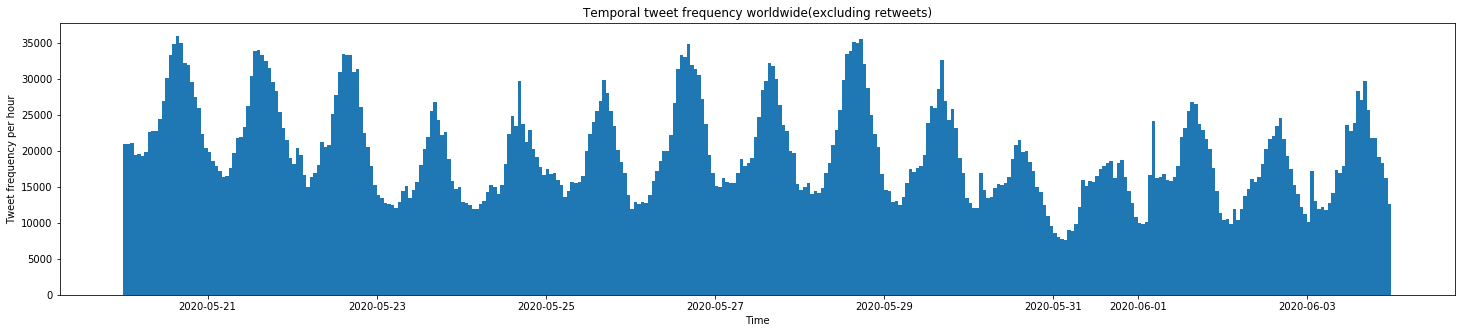

In [28]:
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)
ax.set(title='Temporal tweet frequency worldwide(excluding retweets)', xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(df_text.created_at.values, bins = 24*len(text_list))
plt.show()

In [29]:
df_text.code.value_counts()[:10]

USA    1350748
GBR     500304
IND     485945
CAN     202998
NGA      82679
AUS      62263
ZAF      61844
PAK      58702
IRL      44693
KEN      34934
Name: code, dtype: int64

In [32]:
def getTermFrequency(tweets, count):
    tweet_series = tweets.apply(cleanText, args = (False, True, False, True, True, True,))
    tweet_list = [word for tweet in tweet_series for word in tweet]
    counts = Counter(tweet_list).most_common(count)
    counts_df = pd.DataFrame(counts)
    counts_df.columns = ['word', 'frequency']
    return counts_df

In [33]:
def getMovingAverages(df, frac, roll):
    ot = df.sample(frac = frac)
#     ot['created_at'] = pd.to_datetime(ot['created_at'])
    ot.index = pd.to_datetime(ot['created_at'])
    ot.sort_index(inplace=True)
    ot['expanding'] = ot['vader_score'].expanding().mean()
    ot['rolling'] = ot['vader_score'].rolling(roll).mean()
    return ot

In [34]:
def getPolarClouds(df, max_words):
    
    positive = df[df['sentiment'] == 'positive'].apply(cleanText, axis = 1)
    negative = df[df['sentiment'] == 'negative'].apply(cleanText, axis = 1)
    neutral = df[df['sentiment'] == 'neutral'].apply(cleanText, axis = 1)
    full = df.apply(cleanText, axis = 1)
    
    positive_list = [word for line in positive for word in line.split()]
    negative_list = [word for line in negative for word in line.split()]
    neutral_list = [word for line in neutral for word in line.split()]
    full_list = [word for line in full for word in line.split()]
    
    positive_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(positive_list))

    negative_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(negative_list))

    neutral_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(neutral_list))
    
    full_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(full_list))

    return {'positive': positive_cloud, 'neutral': neutral_cloud, 'negative': negative_cloud, 'all': full_cloud}

In [35]:
def flattenSeries(s):
    return [w for l in s for w in l]

In [36]:
def displayWordcloud(top_words, title, max_words):
    n_components = len(top_words)
    fig, axs = plt.subplots(int(np.ceil(n_components/2)), 2, figsize = (15, 5*int(np.ceil(n_components/2))))
    fig.tight_layout(pad = 0)
    word_cloud = WordCloud(
#         background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
#         collocations=False,
#         normalize_plurals=False
    )
    t = 0
    flag = 0
    
    for i in range(int(np.ceil(n_components/2))):
        for j in range(2):
            axs[i, j].imshow(word_cloud.generate(' '.join(top_words[t])))
            axs[i, j].set_title("May " + str(t+20), fontsize = 10)
            axs[i, j].axis("off")
            t += 1
            if t == n_components:
                flag = 1
                break
        if flag == 1:
            break

    plt.show()

In [37]:
def getHashtagCorr(series, top_n = 20):
#     print(type(series))
    flat = pd.Series(flattenSeries(series))
#     print(flat.head())
    counts = flat.value_counts()
    counts.sort_index()
    popular_hashtags = counts.reset_index()
    popular_hashtags.columns = ['hashtag', 'counts']
    popular_hashtags = popular_hashtags[:top_n]
    
    # find popular hashtags - make into python set for efficiency
    popular_hashtags_set = set(popular_hashtags['hashtag'])
    
    popular_hashtags_series = series.apply(lambda hashtag_list: [hashtag for hashtag in hashtag_list if hashtag in popular_hashtags_set])
    # drop rows without popular hashtag
    popular_hashtags_series = popular_hashtags_series[popular_hashtags_series.apply(lambda hashtag_list: hashtag_list !=[])]
    
    hashtag_df = pd.DataFrame()
    hashtag_df['hashtags'] = popular_hashtags_series
    
    for hashtag in popular_hashtags_set:
        # make columns to encode presence of hashtags
        hashtag_df['{}'.format(hashtag)] = hashtag_df.hashtags.apply(lambda hashtag_list: int(hashtag in hashtag_list))

    hashtag_matrix = hashtag_df.drop('hashtags', axis=1)
    return hashtag_matrix.corr()


In [38]:
def displayCorr(series, min_appearance = 400):
    plt.figure(figsize = (20, 20))
    correlations = getHashtagCorr(series, min_appearance)
    sns.heatmap(correlations, cmap='RdBu', vmin=-1, vmax=1, square = True, cbar_kws={'label':'correlation'})
    plt.show()

# displayCorr(df_country['hashtags'], 600)

In [56]:
def displayDailyCorr(df):
    fig = plt.figure(figsize = (15, 10*int(np.ceil(len(df)/2))))
#     ax = fig.add_subplot(111)
    fig.tight_layout()
    j = np.ceil(len(df)/2)
    
    for t in range(len(df)):
        correlations = df.hashtags[t]
        i=t+1
        plt.subplot(j, 2, i).set_title("May " + str(t+20))
        ax = sns.heatmap(correlations, cmap='RdBu', vmin=-1, vmax=1, square = True, cbar_kws={'label':'correlation'})
        ax.tick_params(colors='white')
#     fig.suptitle(title)
    plt.show()
    
# p = df_country.groupby(['date']).agg({'hashtags': getHashtagCorr}).reset_index()
# displayCorr(p)

In [59]:
def getNamedEntities(text):
    doc = nlp(text)
    return [(X.text, X.label_) for X in doc.ents]

In [41]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [ ]:
def getTopics(df, n_topics, vectorizer, max_df, stem = False):
    df['cleaned_text'] = df.apply(cleanText, args = (stem,), axis = 1)
    
    vectorizer_tf = vectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = max_df, 
                                min_df = 20)
    
    # apply transformation
    tf = vectorizer_tf.fit_transform(df['cleaned_text'])
    
    # for TF DTM
    lda_tf = LatentDirichletAllocation(n_components = n_topics, random_state=0)
    lda_tf.fit(tf)
    
    return {'model': lda_tf, 'tf': tf, 'vectorizer': vectorizer_tf}
    

countries = ['USA', 'IND', 'GBR', 'CAN', 'AUS']
for country in countries:
    df_country = df_text[df_text.code == country]
    
    topics_tfidf = getTopics(df_country, 10, TfidfVectorizer, 0.6, stem = True)
    topics_count = getTopics(df_country, 10, CountVectorizer, 0.6, stem = True)
    
    vis_tfidf = pyLDAvis.sklearn.prepare(topics_tfidf['model'], topics_tfidf['tf'], topics_tfidf['vectorizer'])
    vis_count = pyLDAvis.sklearn.prepare(topics_count['model'], topics_count['tf'], topics_count['vectorizer']) 
    pyLDAvis.save_html(vis_tfidf, main_dir + 'topics/' + country + '_tfidf_topics.html')
    pyLDAvis.save_html(vis_count, main_dir + 'topics/' + country + '_count_topics.html')

In [303]:
df_text.date.unique()

array(['2020-05-21', '2020-05-20', '2020-05-22', '2020-05-23',
       '2020-05-24', '2020-05-25', '2020-05-26', '2020-05-27',
       '2020-05-28', '2020-05-29', '2020-05-30', '2020-06-01',
       '2020-05-31', '2020-06-02', '2020-06-03'], dtype=object)

In [304]:
country = 'USA'
df_country = df_text[(df_text.code == country) & (df_text.date == '2020-05-29')]

clean_text = df_country.full_text.apply(cleanText, args = (False, True, False, True, ))
lemma_lg = clean_text.to_list()
id2word_lg = gensim.corpora.Dictionary(lemma_lg)
id2word_lg.filter_extremes(no_below=20, no_above=0.35)
id2word_lg.compactify()
# id2word_lg.save('train_dict_lg_USA')
corpus_lg = [id2word_lg.doc2bow(text) for text in lemma_lg]

In [305]:
hdp = HdpModel(corpus_lg, id2word_lg, chunksize=10000)
len(hdp.print_topics())

20

In [310]:
lda_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus_lg,
                                           id2word=id2word_lg,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [308]:
lda_gensim

[(0, '0.636*"case" + 0.136*"another" + 0.077*"local" + 0.060*"outbreak" + 0.043*"yesterday" + 0.013*"10000" + 0.000*"total" + 0.000*"10" + 0.000*"lead" + 0.000*"vs"'), (6, '0.327*"thank" + 0.222*"lockdown" + 0.084*"across" + 0.081*"space" + 0.071*"next" + 0.051*"virtual" + 0.042*"small" + 0.027*"friday" + 0.023*"night" + 0.021*"huge"'), (4, '0.274*"know" + 0.219*"keep" + 0.154*"late" + 0.095*"suppose" + 0.083*"follow" + 0.043*"aorde" + 0.040*"population" + 0.034*"estimate" + 0.027*"south" + 0.000*"manage"'), (2, '0.213*"response" + 0.180*"crisis" + 0.140*"everyone" + 0.119*"protect" + 0.087*"act" + 0.081*"end" + 0.046*"big" + 0.034*"quickly" + 0.033*"market" + 0.022*"decision"'), (12, '0.272*"make" + 0.185*"life" + 0.121*"live" + 0.087*"give" + 0.061*"save" + 0.054*"student" + 0.040*"daily" + 0.021*"short" + 0.021*"detail" + 0.020*"park"'), (1, '0.133*"state" + 0.128*"2020" + 0.073*"patient" + 0.067*"order" + 0.059*"report" + 0.057*"could" + 0.056*"spread" + 0.051*"government" + 0.050*

In [311]:
h = pyLDAvis.gensim.prepare(lda_gensim, corpus_lg, id2word_lg)
pyLDAvis.display(h)

In [61]:
country = 'USA'
df_country = df_text[df_text.code == country]

df_country.drop('entities', axis = 1, inplace = True)
df_country['named_ents'] = df_country.full_text.apply(lambda x: getNamedEntities(cleanText(x, keep_hashtags = False)))
df_country.head(10)

,created_at,full_text,retweet_count,favorite_count,date,vader_score,sentiment,code,hashtags,named_ents
2,2020-05-21 00:00:00+00:00,How the COVID “Experts” Got Everything Wrong! ...,0.0,0.0,2020-05-21,-0.1342,neutral,USA,"[TrumpIsMorbidlyObese, CovidDeathRate, endthel...","[(COVID, ORG), (Experts” Got Everything Wrong!..."
3,2020-05-21 00:00:00+00:00,We are LIVE for our #TLCtransform chat on Pivo...,4.0,7.0,2020-05-21,0.4588,positive,USA,[TLCtransform],"[(Purpose, ORG)]"
7,2020-05-21 00:00:00+00:00,Cross-sectional study in Singapore study finds...,1.0,2.0,2020-05-21,0.0000,neutral,USA,[],"[(Singapore, GPE), (only 12.6%, PERCENT), (N95..."
8,2020-05-21 00:00:00+00:00,Severe #COVID19 patients may spend weeks in th...,3.0,6.0,2020-05-21,-0.4019,negative,USA,[],"[(weeks, DATE), (ICU, ORG), (Post-Intensive Ca..."
13,2020-05-21 00:00:00+00:00,A beloved Rockland firefighter and business ow...,6.0,5.0,2020-05-21,-0.0772,neutral,USA,[],"[(Rockland, GPE), (Wednesday, DATE)]"
14,2020-05-21 00:00:00+00:00,A beloved Rockland firefighter and business ow...,1.0,3.0,2020-05-21,-0.0772,neutral,USA,[],"[(Rockland, GPE), (Wednesday, DATE)]"
16,2020-05-21 00:00:00+00:00,Do you know the #HudsonValley parks and trails...,0.0,2.0,2020-05-21,-0.6249,negative,USA,[HudsonValley],[]
18,2020-05-21 00:00:00+00:00,[Intriguing read] 2 studies that demonstrate t...,2.0,3.0,2020-05-21,0.3400,neutral,USA,"[biomedical, biotech]","[(2, CARDINAL)]"
21,2020-05-21 00:00:00+00:00,"Explore the latest in critical care #medicine,...",0.0,0.0,2020-05-21,-0.3400,neutral,USA,[medicine],"[(HAI, ORG)]"
26,2020-05-21 00:00:00+00:00,Blue Bell employee tests positive for #coronav...,4.0,3.0,2020-05-21,0.5574,positive,USA,[],"[(Blue Bell, ORG)]"


In [140]:
def getOrgs(named_ents, e_type):
    return [entity[0] for entity in named_ents if entity[1] == e_type]

# getOrgs(df_country.named_ents.iloc[0], 'GPE')

In [142]:
orgs = df_country.named_ents.apply(getOrgs, args = ('PERSON',))
orgs = flattenSeries(orgs)
stop_words = set(stopwords.words('english'))
stop_words.update(['coronavirusoutbreak', 'coronaviruspandemic', 'covid_19', 'epitwitter', 'ihavecorona', 'amp', 'coronavirus', 'covid19', 'covid-19', 'covid__19', 'pandemic', 'covid'])
orgs = [org for org in orgs if org.lower() not in stop_words]
c = Counter(orgs)
Counter({item: val for item, val in c.items() if val > 50}).most_common()

[('Trump', 27613),
 ('Fauci', 7623),
 ('Karen', 6072),
 ('Donald Trump', 2777),
 ('Ill', 1854),
 ('Joe Biden', 1742),
 ('Dem Chair', 1585),
 ('Kevin', 1412),
 ('Anthony Fauci', 1356),
 ('saf', 1312),
 ('Jaw-drop', 1166),
 ('Chin', 1162),
 ('Cuomo', 1125),
 ('George Floyd', 1099),
 ('Twitter', 993),
 ('ju', 977),
 ('Robin Barnes', 959),
 ('🤣', 927),
 ('Bill', 903),
 ('Joe', 775),
 ('Tony Fauci', 714),
 ('Boris Johnson', 667),
 ('Birx', 634),
 ('Obama', 634),
 ('Soros', 615),
 ('Spencer', 597),
 ('Pelosi', 579),
 ('Nancy Pelosi', 578),
 ('Bill Gates', 570),
 ('Andrew Cuomo', 513),
 ('Dominic Cummings', 507),
 ('Lockdown', 486),
 ('Putin', 466),
 ('Law', 450),
 ('Deems State', 450),
 ('Save Lives', 411),
 ('Moncef Slaoui', 411),
 ('Johnson', 398),
 ('Corona', 393),
 ('Chrissy Teigen', 387),
 ('Gavin Newsom', 386),
 ('Hillary', 382),
 ('I.D', 376),
 ('Donald', 365),
 ('Latino', 362),
 ('Hanneke Schuitemaker', 362),
 ('Fidel Torres', 360),
 ('100k', 356),
 ('Pence', 354),
 ('Asi', 351),
 ('

In [144]:
def getAssociatedTweets(named_ents, query):
    q = query.split()
    r = re.compile(' | '.join(q), flags = re.I | re.X)
    ents = [ent[0] for ent in named_ents]
    ent_string = ' '.join(ents)
    return True if r.search(ent_string) else False
        
df_country.named_ents.apply(getAssociatedTweets, args = ('donald trump',)).value_counts()


False    1291315
True       59433
Name: named_ents, dtype: int64

In [146]:
def searchTweets(tweet, query):
    return True if re.search(query, tweet) else False


# df_query[df_query.full_text.apply(searchTweets, args = ("Dr. Anthony Fauci says there’s a chance",))]

In [612]:
tempo = df_query[df_query.full_text.apply(searchTweets, args = ("Dr. Anthony Fauci says there’s a chance",))]
tempo.iloc[1].full_text

'#wednesdaymorning #WednesdayThoughts #WednesdayVibes Today is Wednesday  \n\nDr. Anthony Fauci says there’s a chance #coronavirus vaccine may not provide immunity for very long.\n\n#ENU200 has shown evidence for long-term successful #COVID19 cure.\n\nhttps://t.co/f4aH3XyEpQ https://t.co/bWXb6oIpC1'

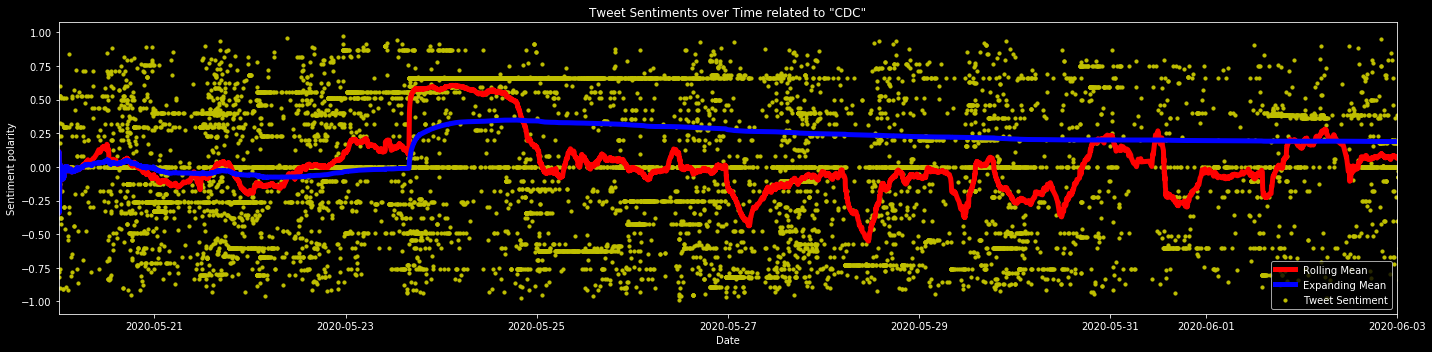

In [151]:
query = 'CDC'
sample = 1
roll = '6H'

df_query = df_country[df_country.named_ents.apply(getAssociatedTweets, args = (query,))]

plt.style.use('dark_background')
ot = getMovingAverages(df_query, sample, roll)
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.scatter(ot['created_at'],ot['vader_score'], label='Tweet Sentiment', s = 10, color = 'y')
ax.plot(ot['created_at'],ot['rolling'], color ='r', label='Rolling Mean', linewidth = 5)
ax.plot(ot['created_at'],ot['expanding'], color='b', label='Expanding Mean', linewidth = 5)
ax.set_xlim(left = pd.to_datetime(min(ot.date.unique())), right = pd.to_datetime(max(ot.date.unique())))
ax.set(title='Tweet Sentiments over Time related to \"{}\"'.format(query), xlabel='Date', ylabel='Sentiment polarity')
ax.legend(loc='best')
fig.tight_layout()
plt.savefig('lol', transparent = True)

In [457]:
t = df_query[(df_query.date == '2020-05-24') | (df_query.date == '2020-05-25')]
t_1 = t[~t.full_text.apply(lambda x: x.startswith('RT'))]
t_1.full_text.iloc[7]

"Why would China accuse the U S military of the #Covid19 outbreak?  Was this a plot by #CorruptDemocrats who owe allegiance to #ObamaGate and not America? Can a former president violate Logan?\nObama is about to meet some of the world's most powerful leaders https://t.co/k1DVBeDq1j"

In [487]:
query = 'george floyd'

df_query = df_country[df_country.named_ents.apply(getAssociatedTweets, args = (query,))]

t = df_query[(df_query.date == '2020-05-24') | (df_query.date == '2020-05-25')]
t_1 = t[~t.full_text.apply(lambda x: x.startswith('RT'))]

text = ". ".join(df_query.full_text.apply(cleanText, args = (False, False, True,)))

# load a spaCy model, depending on language, scale, etc.
nlp = spacy.load("en")

# add PyTextRank to the spaCy pipeline
tr = pytextrank.TextRank()
nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)

doc = nlp(text)

# examine the top-ranked phrases in the document
for p in doc._.phrases:
    print("{:.4f} {:5d}  {}".format(p.rank, p.count, p.text))

0.1161     2  george floyd trump
0.1154    12  george floyd murder
0.1147     5  george floyd protesters
0.1145     1  kill george floyd
0.1139     9  george floyd rioters
0.1138     2  mr. george floyd
0.1137     1  george floyd numbers
0.1136     1  murdered george floyd
0.1135     1  nyc george floyd protests
0.1135    10  conquer george floyd
0.1135     1  dead george floyd
0.1135     2  george floyd avenue
0.1135     1  only george floyd
0.1135     1  x george floyd
0.1134     6  george floyd autopsy
0.1134     2  george floyd funernal
0.1134     2  george perry floyd
0.1134     1  either george floyd
0.1134     1  george floyd march
0.1134     1  george floyd pleads
0.1134     2  george floyd fuck
0.1134     1  george floyd policemen
0.1065     1  america rip george floyd
0.1064     1  amid george floyd protests
0.1064     1  george floyd protests rage
0.1063     3  breonna taylor george floyd
0.0999     1  hijacked george floyd protests downtown
0.0975     1  george floyds death

0.0077     1  science anathema
0.0077     1  the awakening begins
0.0077     2  war
0.0077     1  ample warning
0.0077     1  african-americans’ economic circumstances
0.0077     1  past criminal conduct
0.0076     3  the front lines
0.0076     1  cardiac blood clot
0.0076     1  mean world syndrome
0.0076     2  foley square
0.0076    13  protest
0.0076     1  respiratory complications
0.0076     1  the dreaded iraq war
0.0076     2  the deadly inflammatory disease
0.0076     4  las vegas
0.0076     1  this perfect depiction
0.0076     4  patients
0.0076     2  al qaeda
0.0076     1  so much hate
0.0076     2  melrose avenue
0.0076     3  crime
0.0076     1  the 1918 flu pandemic
0.0075     1  endless tweets
0.0075     1  depression mountain
0.0075     1  cares funds
0.0075     5  march
0.0075    13  son
0.0075     4  employees
0.0075     1  respiratory track
0.0075    11  tragedy
0.0075     2  memorial w/e
0.0075     1  his entire press conference
0.0075     4  flynn
0.0075     1  fa

0.0022     2  an editorial
0.0022     1  👛 of
0.0022     1  the admin
0.0022     1  the administration
0.0022     1  no masks
0.0022     2  the strain
0.0022     1  all a set-up
0.0022     1  its bounds
0.0022     1  ️😷
0.0022     1  well-being
0.0022     1  1,410 •montgomery
0.0022     1  the complaint
0.0022     1  those gains
0.0022     1  the dirt
0.0022     1  [opinion
0.0022     1  his daddy
0.0022     1  the peons
0.0022     2  a haircut
0.0022     1  the entirety
0.0022     1  their mumbling
0.0022     1  a kneel
0.0021     1  the globe
0.0021     1  a picnic
0.0021     2  the past
0.0021     1  a dog
0.0021     1  his momma
0.0021     1  a corporation
0.0021     1  especially the senators
0.0021     1  an essay
0.0021     1  100 bottles
0.0021     1  my cousin
0.0021     1  your ears
0.0021     1  (only a theory
0.0021     1  "motivation
0.0021     1  his minions
0.0021     4  the message
0.0021     4  the age
0.0021     1  the hypocrisy
0.0021     3  a handful
0.0021     1  t

In [460]:
clean_text.iloc[0]

['im', 'going', 'say', 'anyone', 'possibly', 'imagine', 'obama', 'golf', 'course', 'day', 'united', 'states', 'hit', '100000', 'deaths', 'virus', 'tweeted', 'cases', 'deaths', 'declining', 'reaction', 'would']

## Filter by country

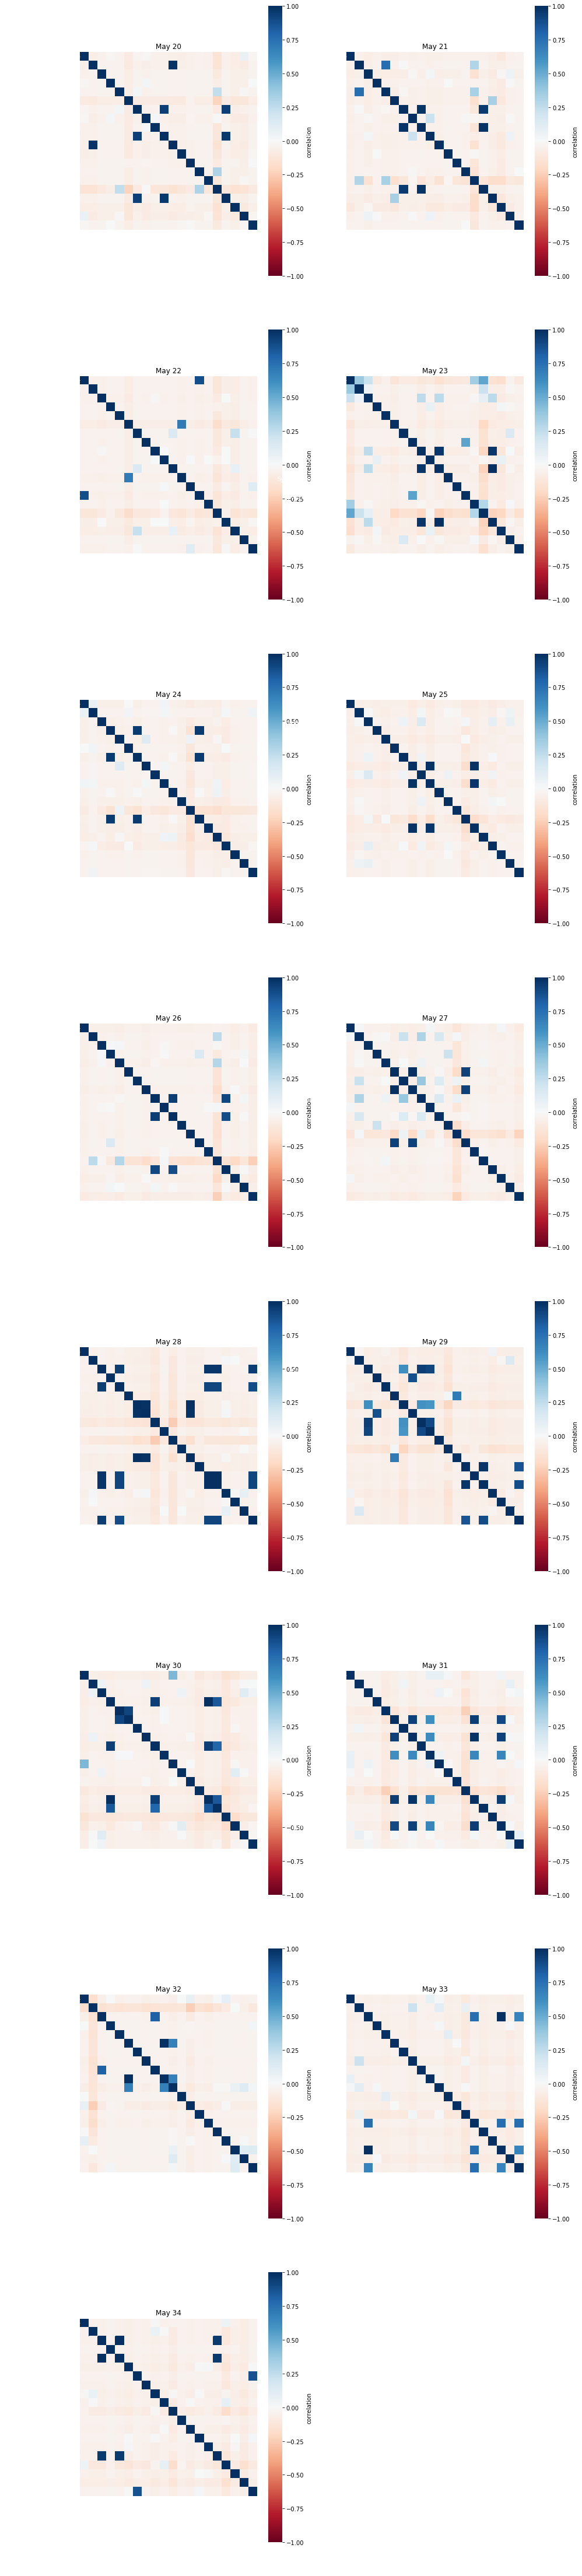

In [57]:
country = 'AUS'
tf_count = 30
sample = 0.8
roll = '1H'

df_country = df_text[df_text.code == country]


# # Term Frequency
# sns.set(style="darkgrid")
# counts_df = getTermFrequency(df_country, tf_count)
# counts_df.columns = ['word', 'frequency']
# fig, ax = plt.subplots(figsize = (8, 8))
# ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)



# # Hashtags of polar words
# clouds = getPolarClouds(df_country, tf_count)

# fig, axs = plt.subplots(2, 2, figsize = (15, 10))
# # fig.suptitle('Clouds of polar words', fontsize = 30)
# fig.tight_layout(pad = 0)

# axs[0, 0].imshow(clouds.get('positive'))
# axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
# axs[0, 0].axis('off')

# axs[0, 1].imshow(clouds.get('negative'))
# axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
# axs[0, 1].axis('off')

# axs[1, 0].imshow(clouds.get('neutral'))
# axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
# axs[1, 0].axis('off')

# axs[1, 1].imshow(clouds.get('all'))
# axs[1, 1].set_title('Words from all tweets', fontsize = 20)
# axs[1, 1].axis('off')
# plt.show()



# # Sentiment scores daywise
# df_country.groupby(['date', 'sentiment']).size().unstack().plot(kind='bar',figsize=(11, 5))



# # Temporal sentiments
# ot = getMovingAverages(df_country, sample, roll)
# fig = plt.figure(figsize=(20,8))
# ax = fig.add_subplot(111)
# ax.scatter(ot['created_at'],ot['vader_score'], label='Tweet Sentiment', s = 10, color = 'y')
# ax.plot(ot['created_at'],ot['rolling'], color ='r', label='Rolling Mean', linewidth = 5)
# ax.plot(ot['created_at'],ot['expanding'], color='b', label='Expanding Mean', linewidth = 5)
# ax.set_xlim([dt.date(2020,5,20),dt.date(2020,5,30)])
# ax.set(title='Tweet Sentiments over Time', xlabel='Date', ylabel='Sentiment polarity')
# ax.legend(loc='best')
# fig.tight_layout()
# plt.show()



# # Clouds of hashtags
# p = df_country.groupby(['date']).agg({'hashtags': flattenSeries}).reset_index()
# displayWordcloud(p.hashtags, "Hashtags cloud", 30)



# Hashtag Correlations
p = df_country.groupby(['date']).agg({'hashtags': getHashtagCorr}).reset_index()
displayDailyCorr(p)

In [177]:
t = df_text[df_text.code == 'GBR']
t.created_at = pd.to_datetime(t.created_at)

# pd.to_datetime(t.iloc[0].created_at).strftime("%m-%d-%Y %H:%M:%S")

In [172]:
t[(t.created_at > '05-22-2020 22:00:00') & (t.created_at < '05-23-2020 04:00:00')]

,created_at,full_text,entities,date,vader_score,sentiment,code
1193561,2020-05-23 00:00:00+00:00,"RT @WHO: ""People with #diabetes are vulnerable...","{'hashtags': [{'text': 'diabetes', 'indices': ...",2020-05-23,-0.8176,negative,GBR
1193563,2020-05-22 23:59:59+00:00,@LeshieLoves Your dad should have been given t...,"{'hashtags': [{'text': 'PPE', 'indices': [49, ...",2020-05-22,-0.8511,negative,GBR
1193591,2020-05-22 23:59:52+00:00,"RT @WHO: ""As the world passes 5 million record...","{'hashtags': [{'text': 'COVID19', 'indices': [...",2020-05-22,0.3612,neutral,GBR
1193601,2020-05-22 23:59:49+00:00,"RT @WHO: ""Maintaining people’s trust in the ab...","{'hashtags': [], 'symbols': [], 'user_mentions...",2020-05-22,0.8860,positive,GBR
1193605,2020-05-22 23:59:48+00:00,RT @RVAwonk: This should be illegal: Through i...,"{'hashtags': [], 'symbols': [], 'user_mentions...",2020-05-22,-0.2500,neutral,GBR
1193618,2020-05-22 23:59:46+00:00,"RT @WHO: ""When health systems are overwhelmed,...","{'hashtags': [], 'symbols': [], 'user_mentions...",2020-05-22,0.3612,neutral,GBR
1193630,2020-05-22 23:59:44+00:00,"RT @peterjukes: On a personal note, I was symp...","{'hashtags': [{'text': 'COVID19', 'indices': [...",2020-05-22,0.0000,neutral,GBR
1193633,2020-05-22 23:59:44+00:00,"RT @WHO: ""A key part of this week’s landmark #...","{'hashtags': [{'text': 'WHA73', 'indices': [45...",2020-05-22,0.3612,neutral,GBR
1193640,2020-05-22 23:59:43+00:00,"RT @MEMEMac00965506: Please watch. If like me,...","{'hashtags': [], 'symbols': [], 'user_mentions...",2020-05-22,0.5719,positive,GBR
1193650,2020-05-22 23:59:39+00:00,"RT @WHO: ""As the world passes 5 million record...","{'hashtags': [{'text': 'COVID19', 'indices': [...",2020-05-22,0.3612,neutral,GBR


In [196]:
a = pd.read_csv(main_dir + 'data/' + '06-06-2020.csv')
a.head()

,id,created_at
0,1269055938599825411,2020-06-05 23:58:08
1,1269055943922221058,2020-06-05 23:58:09
2,1269055944681455619,2020-06-05 23:58:09
3,1269055967536259072,2020-06-05 23:58:15
4,1269055984401596416,2020-06-05 23:58:19


In [198]:
a[-20:]

,id,created_at
63759,1269418778095476736,2020-06-06 23:59:56
63760,1269418783912988675,2020-06-06 23:59:57
63761,1269418785842384897,2020-06-06 23:59:57
63762,1269418795602337798,2020-06-07 00:00:00
63763,1269418796428562433,2020-06-07 00:00:00
63764,1269418796600696834,2020-06-07 00:00:00
63765,1269418796722372609,2020-06-07 00:00:00
63766,1269418796885913603,2020-06-07 00:00:00
63767,1269418796898373632,2020-06-07 00:00:00
63768,1269418797158608898,2020-06-07 00:00:00


In [116]:
text_list[0].iloc[102]

created_at                        Wed May 20 23:59:45 +0000 2020
full_text      RT @CathayPak: China in Action: The Chinese Em...
entities       {'hashtags': [{'text': 'Ramadan', 'indices': [...
user           {'id': 4753492694, 'id_str': '4753492694', 'na...
place                                                        NaN
coordinates                                                  NaN
Name: 102, dtype: object

In [162]:
main_dir = '/home/vca_rishik/rishik/COVID-19-tweets/'
retweet_dir = main_dir + 'data_retweets/'
retweet_ids_dir = main_dir + 'data_retweets_ids/'

# text_list = []
retweet_files = (file for file in os.listdir(retweet_dir) if os.path.isfile(os.path.join(retweet_dir, file)))

for file in sorted(retweet_files):
    print('Reading... ' + file)
    df = pd.read_csv(retweet_dir + file)
    print(str(len(df)) + ' Tweets!')
    df['id'].to_csv(retweet_ids_dir + file, header = 'id', index = None)
    print("Id extraction done!")
    print(file + ' processing done!')
    print()



Reading... 05-20-2020.csv
618997 Tweets!
Id extraction done!
05-20-2020.csv processing done!

Reading... 05-21-2020.csv
578771 Tweets!
Id extraction done!
05-21-2020.csv processing done!

Reading... 05-22-2020.csv
551356 Tweets!
Id extraction done!
05-22-2020.csv processing done!

Reading... 05-23-2020.csv
408986 Tweets!
Id extraction done!
05-23-2020.csv processing done!

Reading... 05-24-2020.csv
420865 Tweets!
Id extraction done!
05-24-2020.csv processing done!

Reading... 05-25-2020.csv
468422 Tweets!
Id extraction done!
05-25-2020.csv processing done!

Reading... 05-26-2020.csv
530600 Tweets!
Id extraction done!
05-26-2020.csv processing done!

Reading... 05-27-2020.csv
509952 Tweets!
Id extraction done!
05-27-2020.csv processing done!

Reading... 05-28-2020.csv
554402 Tweets!
Id extraction done!
05-28-2020.csv processing done!

Reading... 05-29-2020.csv
472344 Tweets!
Id extraction done!
05-29-2020.csv processing done!

Reading... 05-30-2020.csv
371213 Tweets!
Id extraction done!

In [494]:
from lexrank import STOPWORDS, LexRank

documents = ". ".join(df_query.full_text.apply(cleanText, args = (False, False, True,)))

lxr = LexRank(documents, stopwords=STOPWORDS['en'])

sentences = t.full_text.apply(cleanText, args = (False, False, True,)).to_list()

summary = lxr.get_summary(sentences, summary_size=10, threshold=.1)
print(summary)

KeyError: 61

In [509]:
query = 'Anthony Fauci'

# documents = df_country.full_text.apply(cleanText, args = (False, False, True,)).to_list()

# lxr = LexRank(documents, stopwords=STOPWORDS['en'])
df_query = df_country[df_country.named_ents.apply(getAssociatedTweets, args = (query,))]

t = df_query[(df_query.date == '2020-05-24') | (df_query.date == '2020-05-25')]
t_1 = t[~t.full_text.apply(lambda x: x.startswith('RT'))]


sentences = df_query.full_text.apply(cleanText, args = (False, False, True,)).to_list()

summary = lxr.get_summary(sentences, summary_size=10, threshold=0.1)
print(summary)

['Where is Dr. Anthony Fauci?', '"The Mentor Who Made Dr. Anthony Fauci" In this article, Dr. Anthony Fauci explains how his mentor changed his life.…', 'Because Dr Anthony Fauci is the real star.', 'Lol I think Dr Anthony Fauci has been in too long.', 'Have questions? Get answers from Dr. Anthony Fauci RIGHT NOW on', 'Have questions? Get answers from Dr. Anthony Fauci RIGHT NOW on', "Dr. Anthony Fauci hasn't spoken with Trump in two weeks.", "Dr. Anthony Fauci hasn't spoken with Trump in two weeks -", 'Today is Wednesday Dr. Anthony Fauci says there’s a chance', '. Dr. Anthony Fauci unpacks reopening too quickly, more:']


In [603]:
df_query[df_query.full_text.apply(cleanText, args = (False, False, True,)).isin(summary)][['created_at', 'full_text']].to_csv('eventSummary.csv', index = None)

In [ ]:
nlp = en_core_web_lg.load()
df_t = df_country[df_country.date == '2020-05-24']

sent_vecs = {}
docs = []
for tweet in tqdm(df_t.full_text.apply(cleanText, args = (False, False, True,))):
    doc = nlp(tweet)
    docs.append(doc)
    sent_vecs.update({tweet: doc.vector})
sentences = list(sent_vecs.keys())
vectors = list(sent_vecs.values())


x = np.array(vectors)
n_classes = {}
n_unclassified = {}
for i in tqdm(np.arange(0.001, 1, 0.002)):
    dbscan = DBSCAN(eps = i, min_samples = 2, metric = 'cosine').fit(x)
    l = pd.Series(dbscan.labels_)
    n_classes.update({i: len(l.value_counts())})
    n_unclassified.update({i: len(l[l == -1])})


fig = plt.figure()
plt.grid(True)
plt.subplot(2, 1, 1)
plt.plot(list(n_classes.keys()), list(n_classes.values()))
plt.subplot(2, 1, 2)
plt.plot(list(n_unclassified.keys()), list(n_unclassified.values()))


plt.show()

 85%|████████▍ | 424/500 [1:30:39<22:25, 17.71s/it]

In [538]:
dbscan = DBSCAN(eps = 0.041, min_samples = 2, metric = 'cosine').fit(x)
clusters = pd.DataFrame({'label': dbscan.labels_, 'tweets': sentences})
clusters.label.value_counts()

In [544]:
c= clusters[clusters.label == 27].tweets.tolist()
event_df = df_query[df_query.full_text.apply(cleanText, args = (False, False, True,)).isin(c)][['created_at', 'full_text']]
event_df = event_df.sort_values(by = 'created_at').dropna()
event_df.head()

-1     538
 2     140
 27     16
 14      7
 31      7
      ... 
 69      2
 37      2
 36      2
 35      2
 39      2
Name: label, Length: 80, dtype: int64

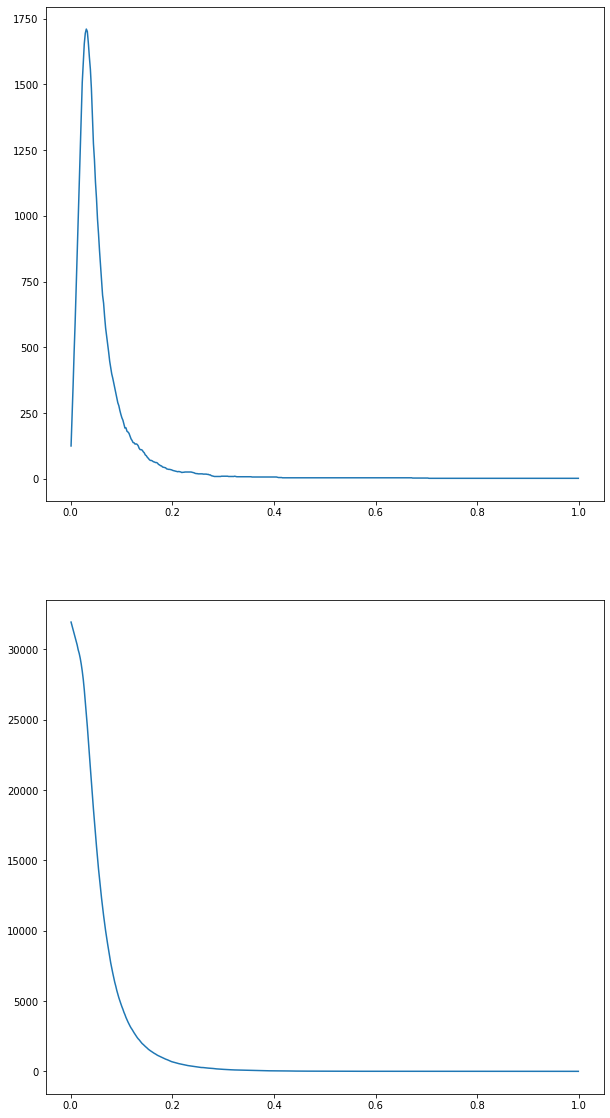

In [574]:
fig = plt.figure(figsize = (10, 20))
plt.grid(True)
plt.subplot(2, 1, 1)
plt.plot(list(n_classes.keys()), list(n_classes.values()))
plt.subplot(2, 1, 2)
plt.plot(list(n_unclassified.keys()), list(n_unclassified.values()))


In [556]:
def get_mean_vector(sents):
    a = np.zeros(300)
    for sent in sents:
        doc = nlp(sent)
        a += doc.vector
    return a/len(sents)

def get_central_vector(sents):
    v = []
    for sent in sents:
        doc = nlp(sent)
        v.append(doc.vector)
    mean = get_mean_vector(sents)
    index = pairwise_distances_argmin_min(np.array([mean]), v)[0][0]
    return sents[index]

In [557]:
get_central_vector(event_df.full_text.apply(cleanText, args = (False, False, True,)).tolist())

'Wow! Look at these numbers! Can’t wait to hear Dr. Fauci and the CDC explain why it is that preferred to str…'

In [561]:
nlp(cleanText(event_df.iloc[0].full_text, False, False, True)).ents

(Fauci, CDC, Democrat, Republican)

In [567]:
clusters.label[clusters.label == -1]

0     -1
2     -1
3     -1
5     -1
6     -1
      ..
873   -1
874   -1
877   -1
878   -1
880   -1
Name: label, Length: 538, dtype: int64

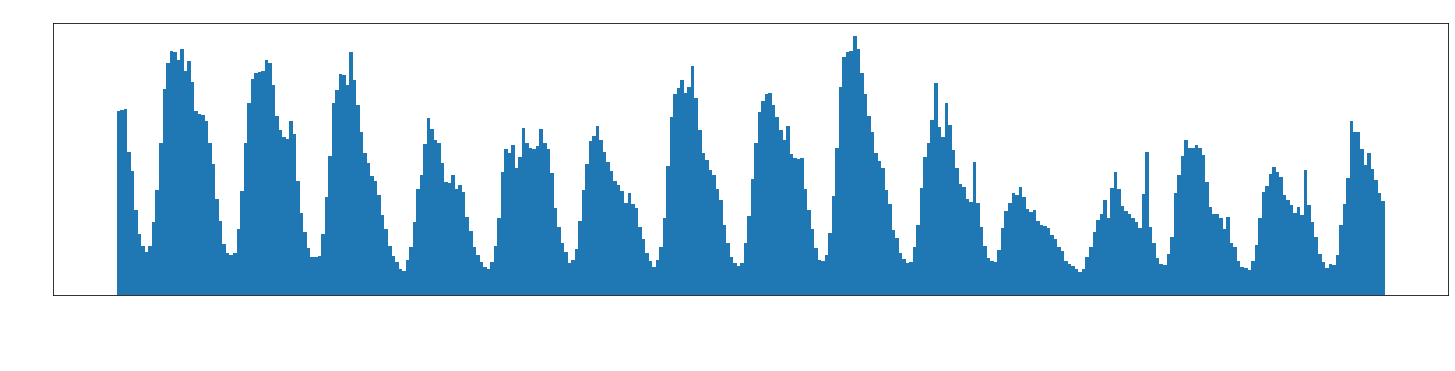

In [68]:
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)
ax.set_title('Temporal tweet frequency for USA', color = 'white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.set(xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(df_country.created_at.values, bins = 24*len(text_list))
plt.xticks(pd.to_datetime(df_country.date.unique()), rotation = 45)
ax.tick_params(colors='white')
plt.show()

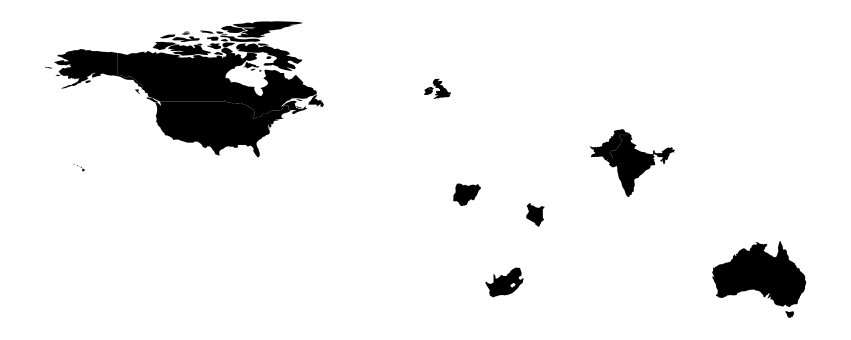

In [138]:
locs = df_text.code
country_df = pd.DataFrame(df_text.code.value_counts()[:10])
# country_df.drop('ATA', inplace = True)
country_df = country_df.reset_index()
country_df.columns = ['code', 'count']

# country_df = temps
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

world = world[['iso_a3', 'geometry']]
world.columns = ['code', 'geometry']

country_freq_df = pd.merge(world, country_df, on='code')
plt.style.use('default')
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(15,15))
# fig.suptitle('Countrywise tweet frequency for a period of ' + str(len(text_list)) + ' days', fontsize = 20)
ax.axis('off')
country_freq_df.plot(ax=ax, column='count', color = 'black')

# plt.savefig('lol', transparent = True)

In [106]:
temps = pd.DataFrame(df_text.code.value_counts()[10:]).reset_index()
temps.columns = ['code', 'count']
temps

,code,count
0,FRA,25547
1,UGA,20903
2,HKG,20814
3,DEU,18899
4,PHL,16556
...,...,...
156,SGS,13
157,CXR,13
158,REU,10
159,KNA,4


In [111]:
plt.style.available

['_classic_test',
 'seaborn-paper',
 'seaborn-muted',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-notebook',
 'Solarize_Light2',
 'seaborn',
 'classic',
 'grayscale',
 'seaborn-ticks',
 'seaborn-pastel',
 'seaborn-whitegrid',
 'tableau-colorblind10',
 'seaborn-white',
 'ggplot',
 'dark_background',
 'fivethirtyeight',
 'fast',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-talk',
 'seaborn-deep',
 'bmh',
 'seaborn-poster',
 'seaborn-bright']